In [16]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import sys

if '..' not in sys.path:
   sys.path.append('..')

from ehr2vec.binary_tmle import estimators, simulate_data, pipelines, vis
importlib.reload(estimators)
importlib.reload(simulate_data)
importlib.reload(pipelines)
importlib.reload(vis)

from ehr2vec.binary_tmle.estimators import IPTW_estimator, AIPW_estimator, TMLE_estimator
from ehr2vec.binary_tmle.vis import display_results
from ehr2vec.binary_tmle.simulate_data import (
    compute_ATE_theoretical_from_data, simulate_binary_data, print_basic_stats)
from ehr2vec.binary_tmle.pipelines import get_scores_for_models_and_estimators

## Simulate binary data and compute theoretical ATE

In [9]:
ALPHA = [0, 0.5, -0.5]
BETA = [-1, 2, 1, -1]

data = simulate_binary_data(10000, alpha=ALPHA, beta=BETA)
ate_th_data = compute_ATE_theoretical_from_data(simulate_binary_data(10000, alpha=ALPHA, beta=BETA), BETA)
# ate_th_model = compute_ATE_theoretical_from_model()
print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
# print(f"from model: {round(ate_th_model, 4)}")

ATE theoretical from data: 0.3498


### Make sure the model is appropriate

In [10]:
print_basic_stats(simulate_binary_data(100, alpha=ALPHA, beta=BETA))

treated patients 51
patients with outcome 52
treated patients with outcome 40
control patients with outcome 12
ORs 3.3333333333333335


In [11]:
# check this models too
models = [{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0, 0.5, -0.5], 'beta': [1, 5, .1, -2]},
          ]
for model in models:
    data = simulate_binary_data(100, alpha=model['alpha'], beta=model['beta'])
    ate_th_data = compute_ATE_theoretical_from_data(data, model['beta'])
    print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
    print_basic_stats(data)

ATE theoretical from data: 0.3403
treated patients 55
patients with outcome 51
treated patients with outcome 36
control patients with outcome 15
ORs 2.4
ATE theoretical from data: 0.3581
treated patients 57
patients with outcome 50
treated patients with outcome 44
control patients with outcome 6
ORs 7.333333333333333
ATE theoretical from data: 0.3216
treated patients 51
patients with outcome 84
treated patients with outcome 51
control patients with outcome 33
ORs 1.5454545454545454


## IPTW estimator of ATE

In [13]:
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA)
ate_iptw, ate_iptw_std = IPTW_estimator(data)    
print(f"ATE IPTW: {ate_iptw}")
print("Difference between theoretical and IPTW ATE:", round(ate_th_data - ate_iptw, 4))

ATE IPTW: 0.3467873054857249
Difference between theoretical and IPTW ATE: -0.0252


## TMLE estimator of ATE

In [14]:
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA, seed=44)
print('ATE from TMLE', TMLE_estimator(data))
print("Difference between theoretical and TMLE ATE:", round(ate_th_data - TMLE_estimator(data)[0], 4))

ATE from TMLE (0.3690113994818418, 0.025416000802256006)
Difference between theoretical and TMLE ATE: -0.0474


## Compare estimators for different N and different models
Use sample std

In [3]:
#patient_numbers = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
estimators = [IPTW_estimator, 
              TMLE_estimator, 
              AIPW_estimator]
patient_numbers = [100, 400, 800, 1600, 3200, 6400, 12800]

models = {'base model':{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          'change alpha':{'alpha': [-0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          'increase beta 1 ':{'alpha': [0, 0.5, -0.5], 'beta': [1, 5, 1, -1]},
          'flip beta 1':{'alpha': [0, 0.5, -0.5], 'beta': [1, -2, 1, -1]},
          'change beta': {'alpha': [0, 0.5, -0.5], 'beta': [.3, 1, -2, 1]},
          'new random model': {'alpha': [1, .5, 3], 'beta': [-1, 2, 1, -1]},
          }

diffs, stds = get_scores_for_models_and_estimators(patient_numbers, models, estimators)


 base model
n=100 n=400 n=800 
 change alpha
n=100 n=400 n=800 
 increase beta 1 
n=100 n=400 n=800 
 flip beta 1
n=100 n=400 n=800 
 change beta
n=100 n=400 n=800 

In [15]:
display_results(models, diffs, stds)

NameError: name 'plt' is not defined

## Add bootstrap confidence intervals

In [5]:
# Helper function to compute and store results
patient_numbers = [200, 500]
estimators = [IPTW_estimator, AIPW_estimator]
models = {'base model':{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          #'change alpha':{'alpha': [-0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          #'increase beta 1 ':{'alpha': [0, 0.5, -0.5], 'beta': [1, 5, 1, -1]},
          'flip beta 1':{'alpha': [0, 0.5, -0.5], 'beta': [1, -2, 1, -1]},
          #'change beta': {'alpha': [0, 0.5, -0.5], 'beta': [.3, 1, -2, 1]},
          }

diffs, stds = get_scores_for_models_and_estimators(patient_numbers, models, estimators, n_bootstraps=20)


 base model
n=200 n=500 
 flip beta 1
n=200 n=500 

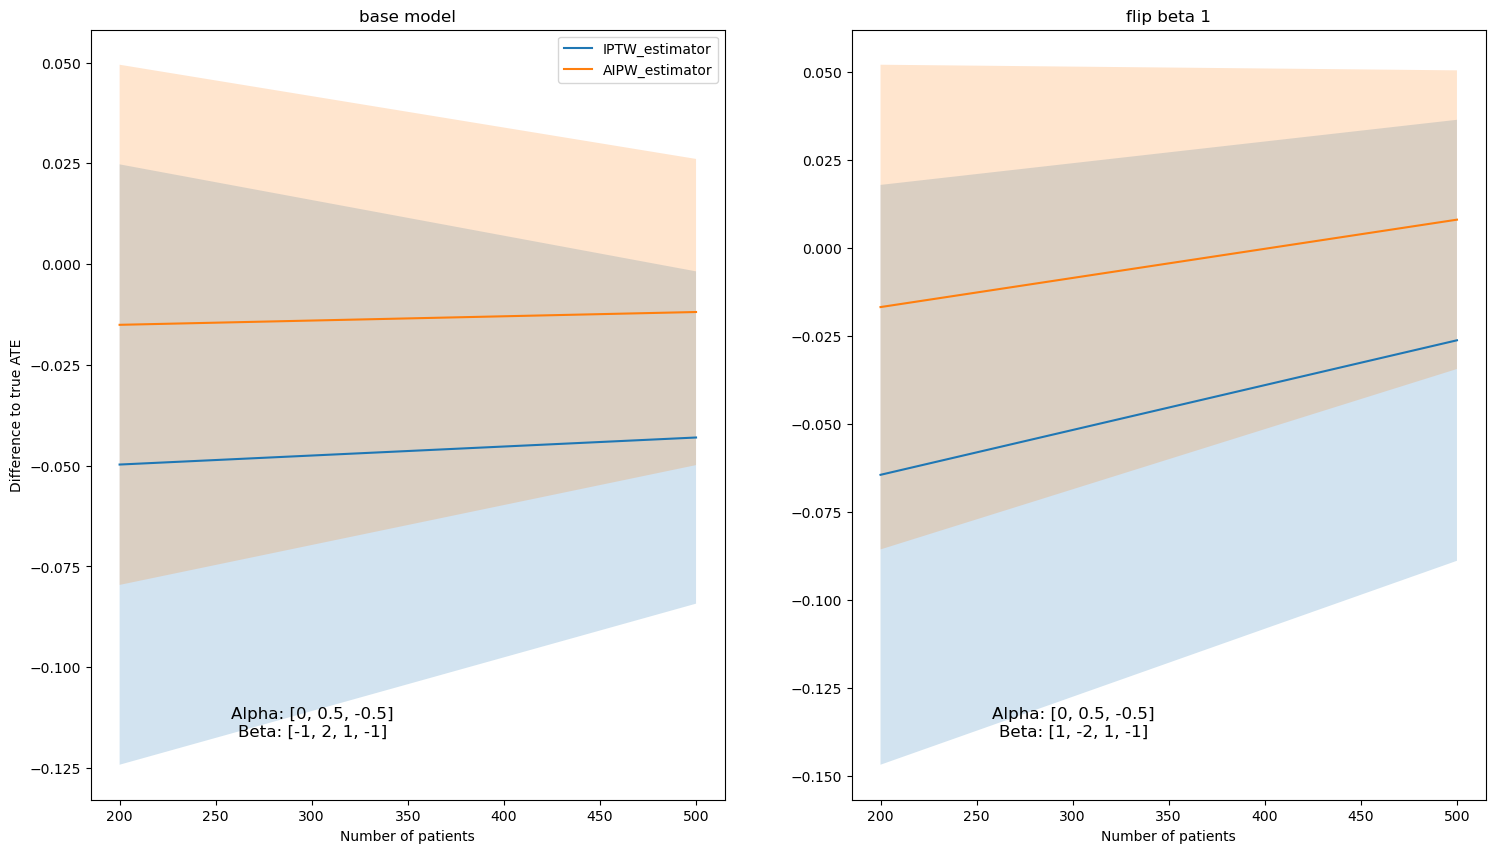

In [6]:
display_results(models, diffs, stds)